In [1]:
from importlib import reload # useful during development to reload packages

import lightkurve as lk
from lightkurve_ext import of_sector, of_sectors, of_2min_cadences
import lightkurve_ext as lke
import lightkurve_ext_tls as lke_tls

from astropy import units as u
from astropy.time import Time

import numpy as np

import matplotlib.pyplot as plt
import matplotlib as matplotlib

from IPython.display import display, HTML, Audio
display(HTML("<style>.container { width:99% !important; }</style>"))

%matplotlib inline

display(HTML("""<style id="hide-beep-css" type="text/css">
  #beep { /* hide the audio control for the beep, generated from tplt.beep() */
    width: 1px;
    height: 1px;
  }
</style>"""));
        
def beep():
    beep_url = "https://upload.wikimedia.org/wikipedia/commons/f/fb/NEC_PC-9801VX_ITF_beep_sound.ogg"    
    display(Audio(url=beep_url, autoplay=True, embed=True, element_id="beep"))

In [8]:
tic, sector, to_detrend = 159951311, 3, False  # WASP-139, very easy
# tic, sector, to_detrend = 270472265, 37, False  # TOI, easy
# tic, sector, to_detrend = 165827520, 37, False  # TOI 3494.01, less obvious (shallower dips but can still be spotted visually)
# tic, sector, to_detrend = 272167060, 37, True   # TOI 3495.01, the shallowest, plus additional long-term variation
# tic, sector, to_detrend = 460984940, 37, True  #  784.01, very shallow
# tic, sector, to_detrend = 446370039, 37, True  # TOI, very shallow
# tic, sector, to_detrend = 141186075, 32, True  # TOI, very shallow and low SNR

max_num_sectors_to_download = 1

# max_num_sectors_to_download = None  # download all sectors, set it to a number to cap it, with the supplied sector as the centor of the slice to donwload

# one-time config for query cache
lk.search.sr_cache.cache_dir = 'data'

def limit_sr_to_download(sr):
    if max_num_sectors_to_download is None:
            return sr
    return lke.of_sector_n_around(sr, sector, num_additions=max_num_sectors_to_download-1)

try:    
    lcf_coll, sr, sr_unfiltered = lke.download_lightcurves_of_tic_with_priority(tic, download_filter_func=limit_sr_to_download, download_dir="./data")
finally:
    beep()  # a beep to remind the users that the data has been downloaded

lcf_coll

Note: there are products not supported by Lightkurve, which are excluded from download.
9 rows filtered ; 2 fast (20secs) products.


#,mission,year,author,exptime,target_name,distance,proposal_id
,,,,s,,arcsec,
0,TESS Sector 03,2018,SPOC,120,159951311,0.0,"G011112 , G011183"
1,TESS Sector 04,2018,SPOC,120,159951311,0.0,"G011112 , G011183"
2,TESS Sector 30,2020,SPOC,120,159951311,0.0,"G03278 , G03181 , G03106"
3,TESS Sector 31,2020,SPOC,120,159951311,0.0,"G03278 , G03181 , G03106"


TIC 159951311 	#sectors: 1 ; 3 - 3
   sector 3: 	camera = 3 ; ccd = 1


LightCurveCollection of 1 objects:
    0: <TessLightCurve LABEL="TIC 159951311" SECTOR=3 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>

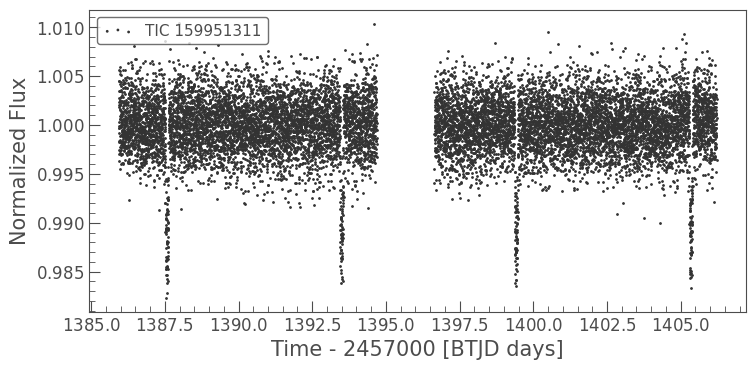

In [9]:
lc_stitched = (
    of_sectors(lcf_coll, sector)
#     of_sectors(lcf_coll, 37, 38)
    .stitch()  # stitch also normalize the flux, needed for TLS
    .remove_outliers(sigma=7)
    .remove_nans()
)

lc = lc_stitched   # .truncate(2308.5, None)
lc.scatter()

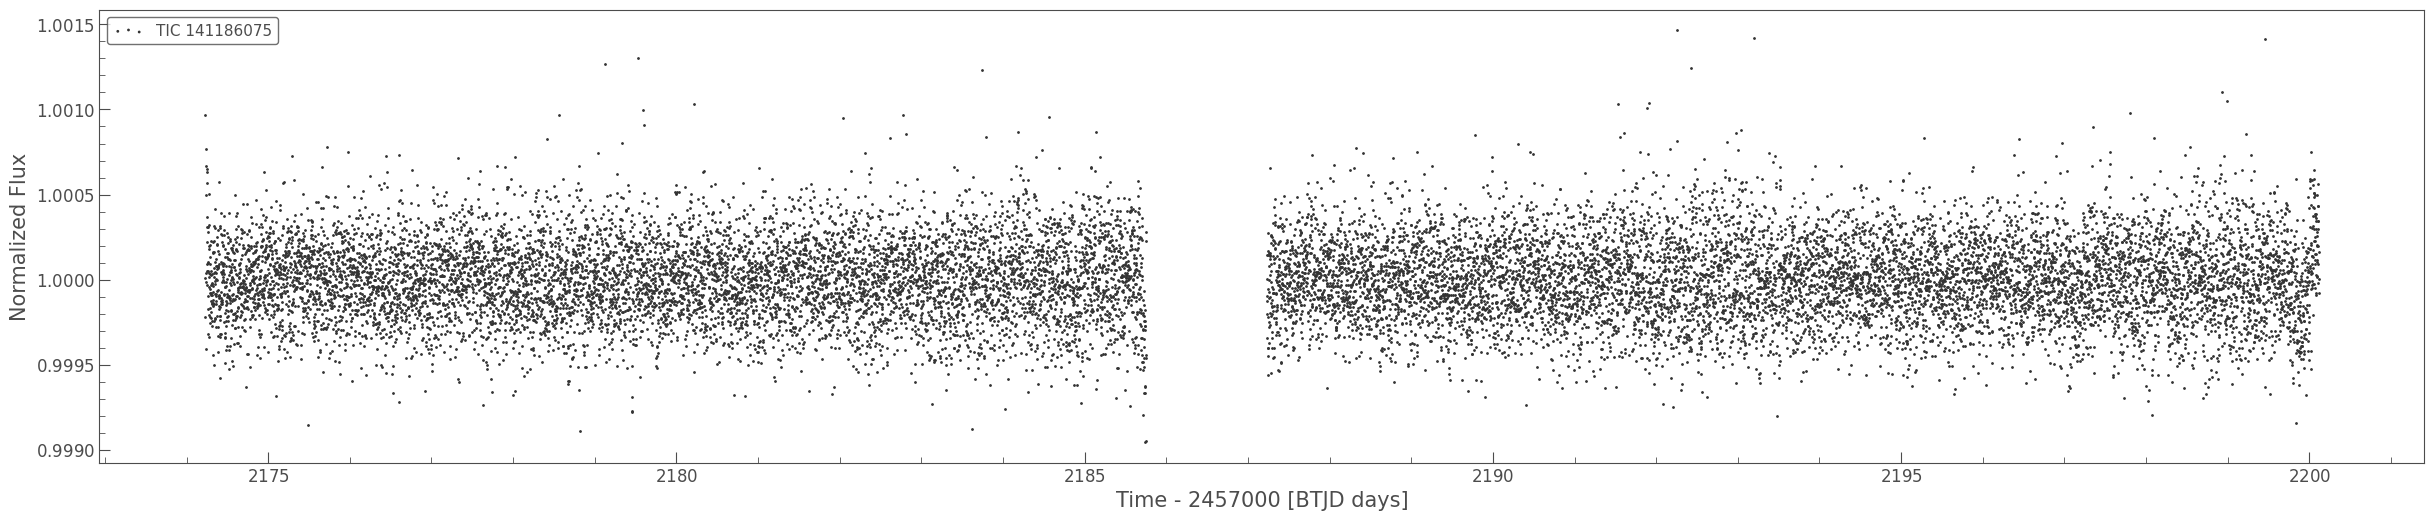

In [4]:
window_length = 72 / 24

if to_detrend:
  lc_flattend = lc_stitched.flatten(window_length=lke.to_window_length_for_2min_cadence(window_length))
  with plt.style.context(lk.MPLSTYLE):
        ax = plt.figure(figsize=(30, 6)).gca()
  ax = lc_flattend.scatter(ax=ax)
  lc = lc_flattend

In [10]:
def plot_pg_n_mark_max(pg, ax=None):
    ax = pg.plot(ax=ax, view="period")
    ax.axvline(pg.period_at_max_power.value, c="blue", alpha=0.4)
    max_text = f"Power: {pg.max_power:.2f}, Period: {pg.period_at_max_power:.4f}, Depth: {pg.depth_at_max_power:.6f}"
    x, y = pg.period_at_max_power.value, pg.max_power * 0.9
    x_mid = ((pg.period.max() - pg.period.min()) / 2 + pg.period.min()).value
    horizontalalignment = "left" if x < x_mid else "right"
    ax.text(x, y, " " + max_text + " ", c="blue", horizontalalignment=horizontalalignment)
    return ax

DEBUG:lightkurve_ext_tls:TLS.from_lightcurve() args: {'show_progress_bar': True}
DEBUG:lightkurve_ext_tls:catalog_info() elapsed time: 236.530029296875ms
DEBUG:lightkurve_ext_tls:TLS.from_lightcurve() - tls.power() args: {'show_progress_bar': True, 'u': (0.4136, 0.1999), 'R_star': 0.846671, 'R_star_min': 0.7917137, 'R_star_max': 0.9016282999999999, 'M_star': 0.87, 'M_star_min': 0.763788, 'M_star_max': 0.976212}
  0%|                                                                    | 0/2167 periods | 00:00<?

Transit Least Squares TLS 1.0.28 (13 June 2021)
Creating model cache for 36 durations
Searching 13032 data points, 2167 periods from 0.502 to 10.139 days
Using all 12 CPU threads


100%|█████████████████████████████████████████████████████████████| 2167/2167 periods | 00:12<00:00


lightkurve.Periodogram properties:
        Attribute                   Description            Units
------------------------- -------------------------------- -----
                 targetid                        159951311      
             default_view                           period      
                    label                    TIC 159951311      
                time_unit                              day      
       depth_at_max_power                           0.0114      
    duration_at_max_power                           0.1137     d
  false_alarm_probability                           0.0001      
   frequency_at_max_power                           0.1689 1 / d
                max_power                          16.3588      
      period_at_max_power                           5.9199     d
  period_at_max_power_err                           0.0354     d
         snr_at_max_power                          63.2797      
                     chi2                    array (216

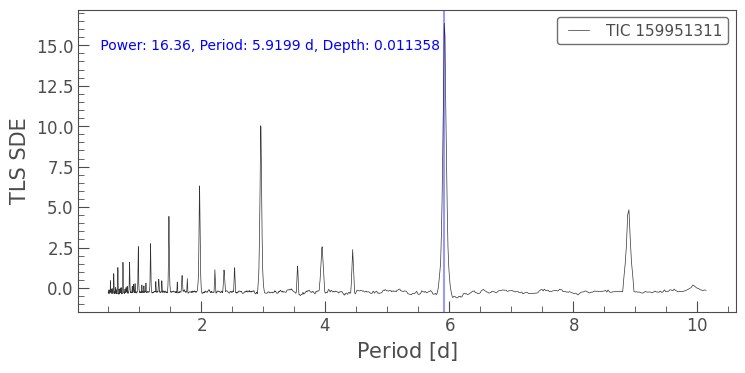

In [12]:
# reload(lke_tls)

import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger('lightkurve_ext_tls')
logger.setLevel(logging.DEBUG)

pg = lke_tls.TransitLeastSquaresPeriodogram.from_lightcurve(lc, 
#                                                             derive_stellar_priors=False, 
                                                            # oversampling_factor: 
                                                            # for period grid granulatrity. default is 3, increase it to increase effieicency, 
                                                            # espcially given that the stellar priors is used to cut down the period grid initally
#                                                             oversampling_factor= 5,  
#                                                             use_threads=6,
                                                            show_progress_bar=True,
#                                                             minimum_period=10 * u.day,
#                                                             maximum_period=26 * u.day,
#                                                             # for typical TESS 1-sector data, TLS's default will prevent users from finding 2 transits within 1 sector, overriding it
#                                                             n_transits_min=1 # override the default 2, which could override maximum_period if lc's duration / 2 < maximum_period given
                                                           )
pg.show_properties();
print("transit_time_at_max_power ", pg.transit_time_at_max_power)
plot_pg_n_mark_max(pg);

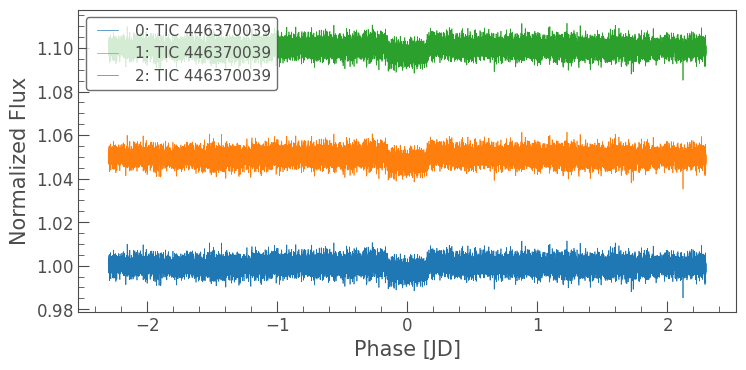

In [361]:
lc_f1, _ = pg.fold(lc)
lc_f2, _ = pg.fold(lc)
lc_f3, _ = pg.fold(lc)

lk.LightCurveCollection([lc_f1, lc_f2, lc_f3]).plot(offset = 0.05);

In [13]:
def plot_lc_with_model(lc, pg):
    # with plt.style.context(lk.MPLSTYLE):
    #     ax = plt.figure(figsize=(15, 6)).gca()
    ax1 = lc.scatter()
    lc[pg.get_transit_mask()].scatter(ax=ax1, c="orange", marker="x", s=9, label="in transits")

    ax2 = lc.scatter()
    pg.get_transit_model().plot(ax=ax2, c="red", alpha=0.9, linewidth=2)

    # folded, zoom -in
    ax_f = None
    if getattr(pg, "fold", None): 
        # only TLS Periodogram suppots it at the moment
        lc_f, lc_model_f = pg.fold(lc)
        ax_f = lc_f.scatter()
        lc_model_f.scatter(ax=ax_f, c="red")
        ax_f.set_xlim(-pg.duration_at_max_power.value, pg.duration_at_max_power.value)
    else:
        print("Fold-and-plot skipped")

    return ax1, ax2, ax_f

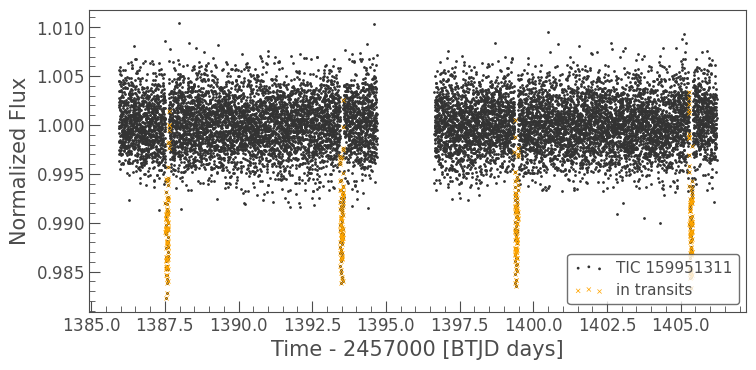

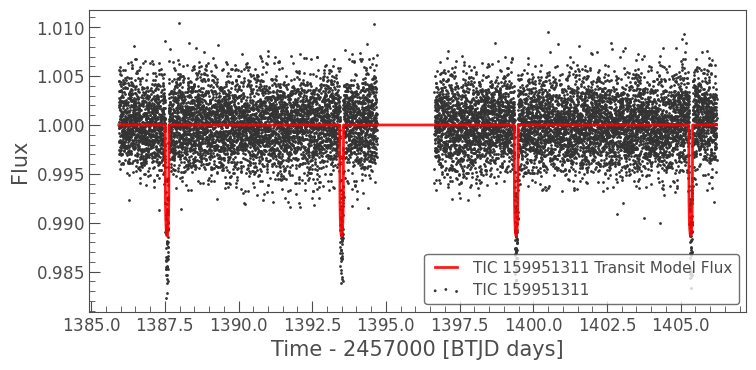

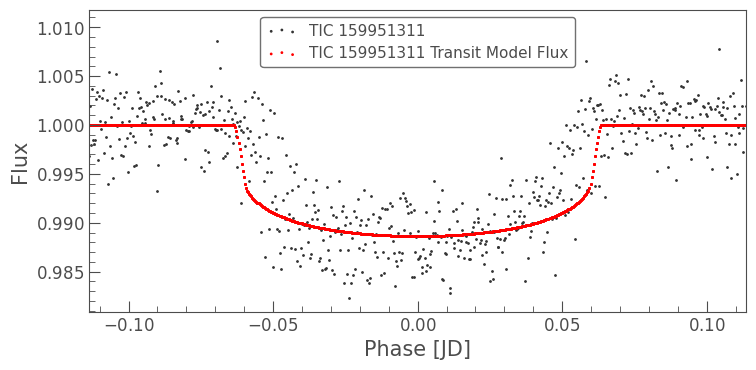

In [14]:
plot_lc_with_model(lc, pg);

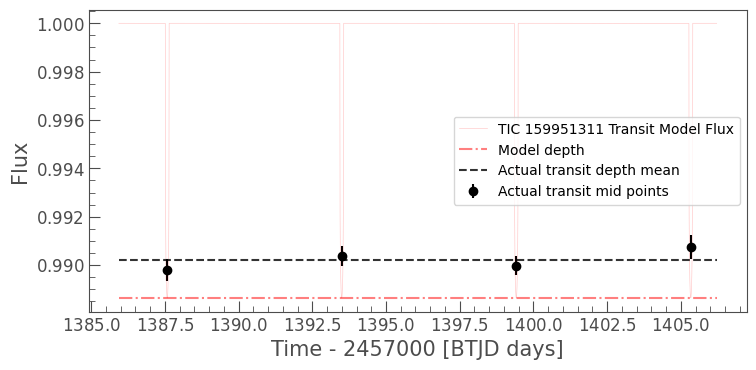

In [15]:
# Check if the transit depths are consistent
def errorbar_transit_depth(pg):
    lc_model = pg.get_transit_model()
    ax = lc_model.plot(c="red", alpha=0.2)
    
    time = [lc_model.time.min().value, lc_model.time.max().value]    
    ax.plot(time, [1 - pg.depth_at_max_power, 1 - pg.depth_at_max_power], linestyle="-.", c="red", alpha=0.5, label="Model depth")

    transit_depth_mean = np.nanmean(pg.transit_depth)  # note pg._TLS_result.depth_mean[0] would be more accurate, it also has the error
    ax.plot(time, [1 - transit_depth_mean , 1 - transit_depth_mean ], linestyle="--", c="black", alpha=0.8, label="Actual transit depth mean")
    
    ax.errorbar(pg.transit_time.value, 1 - pg.transit_depth, pg.transit_depth_err, fmt='o', color='black', label="Actual transit mid points")
    
    ax.legend()
    return ax

ax = errorbar_transit_depth(pg);
# ax.set_xlim(2312, 2313);

### Check if the peak result likely to represent a real dip

In [16]:
from types import SimpleNamespace

def validate_tls_n_report(pg, to_display=True):
    # See https://transitleastsquares.readthedocs.io/en/latest/Python%20interface.html#return-values
    # for TLS return values
    
    def metrics(name, value, flag_func=None):
        to_flag = flag_func(value) if flag_func is not None else False
        return SimpleNamespace(name=name, value=value, flag=to_flag)

    def output_metrics(metrics_list):
        def html(m):
            flag_style="color: red; font-weight: bold" if m.flag else ""
            name = m.name.replace("\n", "<br>")
            return f"""<tr><td>{name}</td><td style="{flag_style}">{m.value}</td></tr>"""
        
        html_body = "\n".join([html(m) for m in metrics_list])
        return f"""
<table>
<tr><th>Metrics</th><th>Value</th</tr>
{html_body}
</table>
        """

    # Use False Alarm Probability (on white noise only run) 
    # threshold at 0.1%, or SDE 8.3
    # OPEN: consider to use the more srignent threshold 0.01% / SDE 9.1 
    # (the value computed is optimistic as it's based on white noise data, actual data has some correlation varation (poink noise))
    # See: 
    # https://transitleastsquares.readthedocs.io/en/latest/FAQ.html#false-alarm-probability
    
    def flag_fap(false_alarm_probability):
        return np.isnan(false_alarm_probability) or false_alarm_probability > 0.001        
    
    def flag_sde(sde):
        return sde < 8.3

    def flag_snr(snr):        
        return snr < 10 # arbitary for now
    
    def flag_odd_even(odd_even_mismatch):
        return odd_even_mismatch > 3  # i.e, > 3 sigma

    def flag_empty_transit_count(empty_transit_count):
        return empty_transit_count > 0
    
    metrics_list = [
        metrics("Period", pg.period_at_max_power),
        metrics("- Period error\n(half width at half max)", pg.period_at_max_power_err),
        metrics(f"Epoch ({pg.transit_time_at_max_power.format.upper()})", pg.transit_time_at_max_power),
        metrics("Duration", pg.duration_at_max_power),
        metrics("Depth (Model)", pg.depth_at_max_power),
        metrics("Depth (Mean)", 1 - pg._TLS_result.depth_mean[0]),  # mean of all in-transit flux, need 1 - TLS_result
        metrics("- Depth (Mean) error", pg._TLS_result.depth_mean[1]),
        metrics("Period grid size", len(pg.period)),  # larger period grid enerally results in more accurate period and better SDE
        metrics("FAP (white noises)", pg.false_alarm_probability, flag_fap),
        metrics("SDE (Power)", pg.max_power, flag_sde),
        metrics("SR (Log likelihood)", np.max(pg.sr)),  # TODO not too useful in normaized form, it's practically always 1
        metrics("SNR", pg.snr_at_max_power, flag_snr),
        metrics("SNR per transit", pg._TLS_result.snr_per_transit),
        metrics("SNR (pink)\nconerns if greatly different from SNR", pg._TLS_result.snr_pink_per_transit),
        metrics("Empty Transits\nactual period might be double", pg._TLS_result.empty_transit_count, flag_empty_transit_count),
        metrics("Odd-even mismatch (sigma)", pg._TLS_result.odd_even_mismatch, flag_odd_even),
    ]
        
    html = output_metrics(metrics_list)
    if to_display:
        return display(HTML(html))
    else:
        return html
    
    
validate_tls_n_report(pg);

In [220]:
pg._TLS_result

{'SDE': 7.524174886033521,
 'SDE_raw': 7.4524210369523916,
 'chi2_min': 0.150375544328249,
 'chi2red_min': 8.747850164528738e-06,
 'period': 4.602606408046798,
 'period_uncertainty': 0.05962319426980711,
 'T0': 2307.9494342806042,
 'duration': 0.3624520955571602,
 'depth': 0.9976085498470779,
 'depth_mean': (0.997913357609108, 7.934480842381504e-05),
 'depth_mean_even': (0.9981604383803543, 0.00011264309488077695),
 'depth_mean_odd': (0.9976684857336453, 0.00011109142570037393),
 'transit_depths': array([0.99814508, 0.99763817, 0.99786141, 0.9977013 , 0.99848349,
        0.99766599]),
 'transit_depths_uncertainties': array([0.00020547, 0.00018933, 0.0001864 , 0.00019926, 0.00019078,
        0.00018845]),
 'rp_rs': 0.04475888348255993,
 'snr': 27.59943597274892,
 'snr_per_transit': array([10.03860581, 12.78199409, 11.573834  , 12.44032091,  8.09640851,
        12.63141751]),
 'snr_pink_per_transit': array([10.11369835, 12.87760821, 11.66041063, 12.53337919,  8.268608  ,
        12.72590

DEBUG:lightkurve_ext_tls:TLS.from_lightcurve() args: {'derive_stellar_priors': True, 'use_threads': 6, 'show_progress_bar': True}
DEBUG:lightkurve_ext_tls:catalog_info() elapsed time: 233.45556640625ms
DEBUG:lightkurve_ext_tls:TLS.from_lightcurve() - tls.power() args: {'use_threads': 6, 'show_progress_bar': True, 'u': (0.4136, 0.1999), 'R_star': 0.846671, 'R_star_min': 0.7917137, 'R_star_max': 0.9016282999999999, 'M_star': 0.87, 'M_star_min': 0.763788, 'M_star_max': 0.976212}
  0%|                                                                    | 0/2167 periods | 00:00<?

Transit Least Squares TLS 1.0.28 (13 June 2021)
Creating model cache for 36 durations
Searching 2634 data points, 2167 periods from 0.502 to 10.139 days
Using 6 of 12 CPU threads


100%|█████████████████████████████████████████████████████████████| 2167/2167 periods | 00:05<00:00


lightkurve.Periodogram properties:
        Attribute                   Description            Units
------------------------- -------------------------------- -----
                 targetid                        159951311      
             default_view                           period      
                    label            TIC 159951311(binned)      
                time_unit                              day      
       depth_at_max_power                           0.0114      
    duration_at_max_power                           0.1149     d
  false_alarm_probability                           0.0001      
   frequency_at_max_power                           0.1689 1 / d
                max_power                          21.7979      
      period_at_max_power                           5.9198     d
  period_at_max_power_err                           0.0296     d
         snr_at_max_power                          49.6873      
                     chi2                    array (216

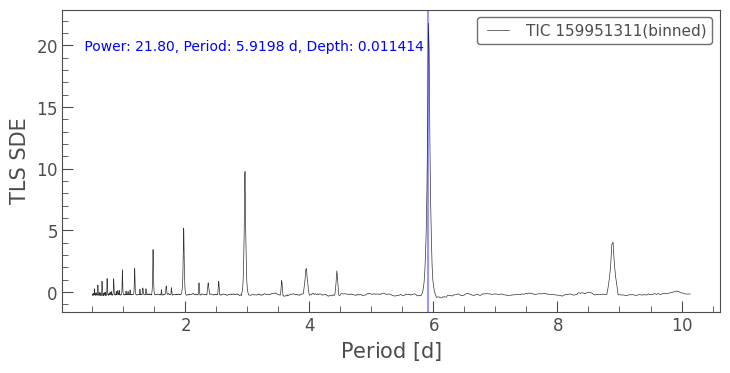

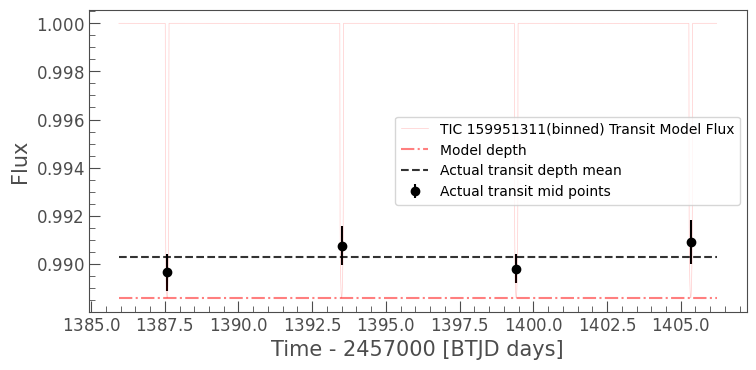

In [17]:
# The above transdit dpeth variation seems to be quite large
# see if a small binning would change the result
# - It does not change the result


lc_b = lc.bin(time_bin_size=10*u.min)
lc_b.meta.update(lc.meta)
lc_b.label += "(binned)"

pg_b = lke_tls.TransitLeastSquaresPeriodogram.from_lightcurve(lc_b, 
                                                            derive_stellar_priors=True, 
                                                            use_threads=6,
                                                            show_progress_bar=True,
#                                                             minimum_period=10 * u.day,
#                                                             maximum_period=26 * u.day,
#                                                             # for typical TESS 1-sector data, TLS's default will prevent users from finding 2 transits within 1 sector, overriding it
#                                                             n_transits_min=1 # override the default 2, which could override maximum_period if lc's duration / 2 < maximum_period given
                                                           )
pg_b.show_properties();
print("transit_time_at_max_power ", pg_b.transit_time_at_max_power)
plot_pg_n_mark_max(pg_b);
errorbar_transit_depth(pg_b);

### Find additional periodic dips

DEBUG:lightkurve_ext_tls:TLS.from_lightcurve() args: {'derive_stellar_priors': True, 'use_threads': 6, 'show_progress_bar': True}
DEBUG:lightkurve_ext_tls:catalog_info() elapsed time: 197.639404296875ms
DEBUG:lightkurve_ext_tls:TLS.from_lightcurve() - tls.power() args: {'use_threads': 6, 'show_progress_bar': True, 'u': (0.3741, 0.2255), 'R_star': 3.1233, 'R_star_min': 2.946386, 'R_star_max': 3.300214, 'M_star': 1.01, 'M_star_min': 0.878015, 'M_star_max': 1.141985}
  0%|                                                                     | 0/233 periods | 00:00<?

Transit Least Squares TLS 1.0.28 (13 June 2021)
Creating model cache for 37 durations
Searching 15635 data points, 233 periods from 3.295 to 12.551 days
Using 6 of 12 CPU threads


100%|███████████████████████████████████████████████████████████████| 233/233 periods | 00:04<00:00


lightkurve.Periodogram properties:
        Attribute                   Description            Units
------------------------- -------------------------------- -----
                 targetid                        446370039      
             default_view                           period      
                    label                    TIC 446370039      
                time_unit                              day      
       depth_at_max_power                           0.0005      
    duration_at_max_power                           0.3625     d
  false_alarm_probability                              nan      
   frequency_at_max_power                           0.2253 1 / d
                max_power                           0.3896      
      period_at_max_power                           4.4391     d
  period_at_max_power_err                           0.8193     d
         snr_at_max_power                           5.3282      
                     chi2                     array (23

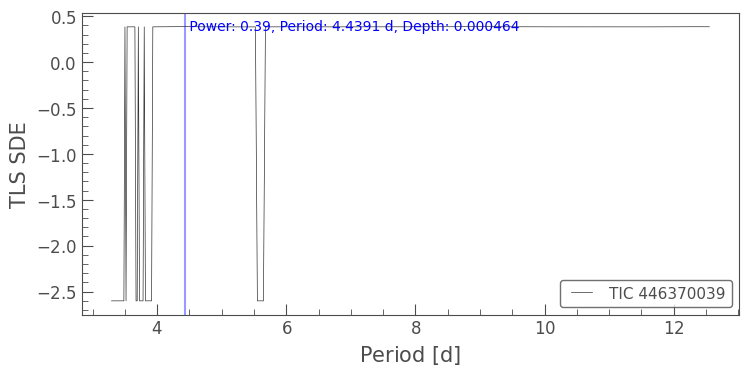

In [187]:
m_tt1 = lc.create_transit_mask(period=pg.period_at_max_power.value, transit_time=pg.transit_time_at_max_power, duration=pg.duration_at_max_power.value)
lc2 = lc[~m_tt1]

pg2 = lke_tls.TransitLeastSquaresPeriodogram.from_lightcurve(lc2, 
                                                            derive_stellar_priors=True, 
                                                            use_threads=6,
                                                            show_progress_bar=True,
#                                                             minimum_period=10 * u.day,
#                                                             maximum_period=pg.period_at_max_power + 0.5 * u.day,
#                                                             # for typical TESS 1-sector data, TLS's default will prevent users from finding 2 transits within 1 sector, overriding it
#                                                             n_transits_min=1 # override the default 2, which could override maximum_period if lc's duration / 2 < maximum_period given
                                                           )
pg2.show_properties();
print("transit_time_at_max_power ", pg2.transit_time_at_max_power)
plot_pg_n_mark_max(pg2);

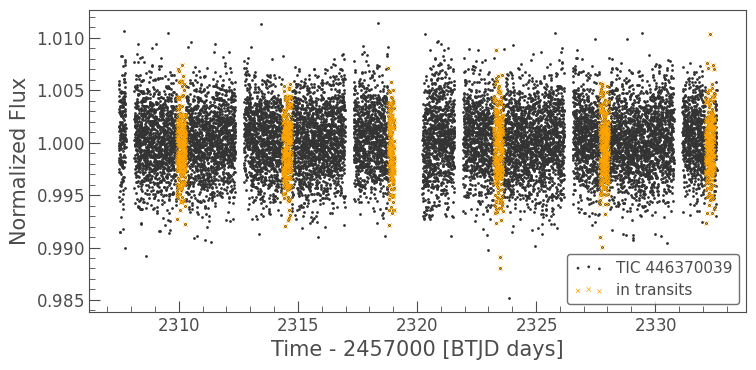

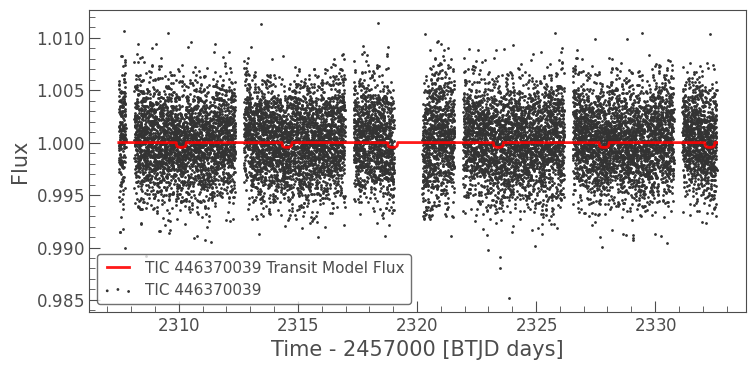

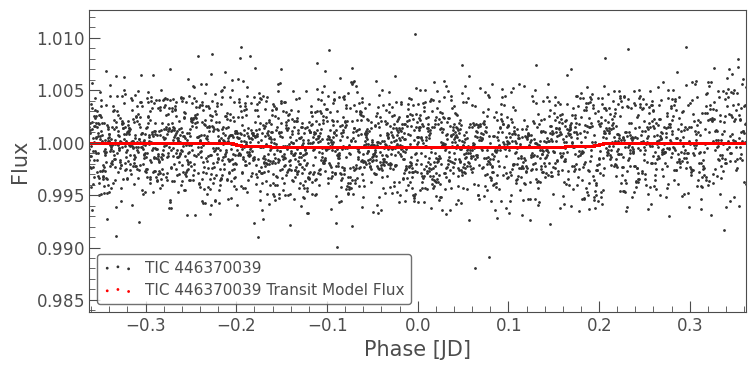

In [184]:
plot_lc_with_model(lc2, pg2);


In [199]:
from transitleastsquares import catalog_info

ab, mass, mass_min, mass_max, radius, radius_min, radius_max = catalog_info(TIC_ID=lc.targetid)
ab, mass, mass_min, mass_max, radius, radius_min, radius_max

((0.3454, 0.2253),
 array(1.07),
 array(nan),
 array(nan),
 array(1.13756),
 array(nan),
 array(nan))

In [117]:
pg._TLS_result

{'SDE': 18.636211231302838,
 'SDE_raw': 17.79355339961697,
 'chi2_min': 562.5031104756602,
 'chi2red_min': 0.5569337727481783,
 'period': 2.750437978957704,
 'period_uncertainty': 0.01119225216105968,
 'T0': 2310.3722218435714,
 'duration': 0.08459352011224947,
 'depth': 0.9908664436470078,
 'depth_mean': (0.9920493522111107, 0.0005563816648482153),
 'depth_mean_even': (0.9917795938604018, 0.000801436074378527),
 'depth_mean_odd': (0.9923191105618197, 0.000766408064271885),
 'transit_depths': array([0.99123509, 0.99107753, 0.9914417 , 0.99300905,        nan,
        0.9911214 , 0.99056575, 0.9937186 , 0.99345659]),
 'transit_depths_uncertainties': array([0.00155261, 0.00083262, 0.00180983, 0.0011195 ,        nan,
        0.00140008, 0.00088529, 0.00182914, 0.00155576]),
 'rp_rs': 0.08594628380844878,
 'snr': 26.70338847220772,
 'snr_per_transit': array([10.09721826, 10.2787338 ,  9.85920871,  8.05361488,  0.        ,
        10.22819647, 10.8683074 ,  8.0903225 ,  8.42778648]),
 'snr_p

In [19]:
pg_bls.sde = (pg_bls.max_power - np.mean(pg_bls.power)) / np.std(pg_bls.power)

lightkurve.Periodogram properties:
        Attribute                   Description            Units
------------------------- -------------------------------- -----
                 targetid                        159951311      
             default_view                           period      
                    label                    TIC 159951311      
                time_unit                              day      
       depth_at_max_power                           0.0106      
    duration_at_max_power                              0.1     d
   frequency_at_max_power                           0.1686 1 / d
                max_power                        2225.6762      
      period_at_max_power                           5.9303     d
                      sde                          17.8344      
                    depth                    array (2361,)      
                 duration                    array (2361,)     d
                     flux                   array (1303

lightkurve.Periodogram properties:
        Attribute                   Description            Units
------------------------- -------------------------------- -----
                 targetid                        159951311      
             default_view                           period      
                    label                    TIC 159951311      
                time_unit                              day      
       depth_at_max_power                           0.0106      
    duration_at_max_power                              0.1     d
   frequency_at_max_power                           0.1686 1 / d
                max_power                        2225.6762      
      period_at_max_power                           5.9303     d
                    depth                    array (2361,)      
                 duration                    array (2361,)     d
                     flux                   array (13032,)      
                frequency                    array (236

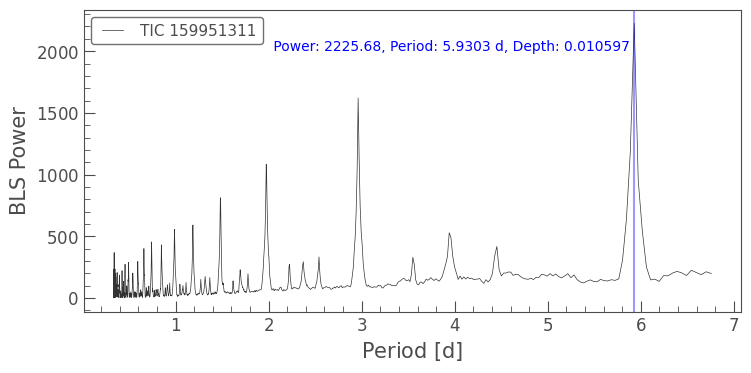

In [18]:
pg_bls = lc.to_periodogram(method="bls"
#                            , minimum_period=1
#                            , maximum_period=30
                          )
pg_bls.show_properties()
plot_pg_n_mark_max(pg_bls);
print("transit_time_at_max_power: ", pg_bls.transit_time_at_max_power)
sde = (pg_bls.max_power - np.mean(pg_bls.power)) / np.std(pg_bls.power)
print("SDE: ", sde)

Fold-and-plot skipped


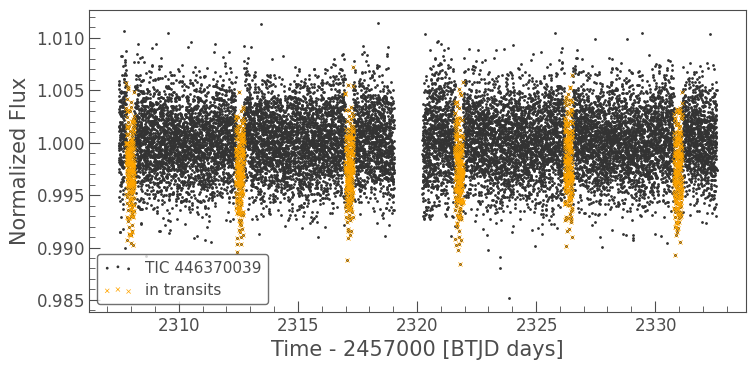

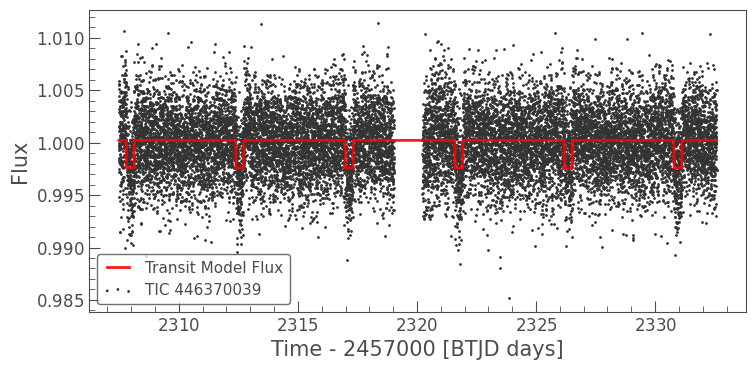

In [197]:
import warnings
with warnings.catch_warnings():
    # avoid warnings about using max power values 
    warnings.filterwarnings("ignore", message=".*Using.*")
    logger = logging.getLogger('lightkurve.periodogram')
    logger.setLevel(logging.ERROR)
    plot_lc_with_model(lc, pg_bls);

In [337]:
from types import SimpleNamespace
from transitleastsquares.stats import FAP as fap_from_tls

def validate_bls_n_report(pg, to_display=True):
    # See https://docs.astropy.org/en/stable/timeseries/bls.html
    # and 
    # https://docs.astropy.org/en/stable/api/astropy.timeseries.BoxLeastSquares.html#astropy.timeseries.BoxLeastSquares.compute_stats
    
    def metrics(name, value, flag_func=None):
        to_flag = flag_func(value) if flag_func is not None else False
        return SimpleNamespace(name=name, value=value, flag=to_flag)

    def output_metrics(metrics_list):
        def html(m):
            flag_style="color: red; font-weight: bold" if m.flag else ""
            name = m.name.replace("\n", "<br>")
            return f"""<tr><td>{name}</td><td style="{flag_style}">{m.value}</td></tr>"""
        
        html_body = "\n".join([html(m) for m in metrics_list])
        return f"""
<table>
<tr><th>Metrics</th><th>Value</th</tr>
{html_body}
</table>
        """

    
    # SDE, Signal Detection Efficiency, eq 6 of the paper
    # assuming the power of the BLS is proportinal to SR (Signal Residue, defined in eq 5, which is a form of chi-square statistics)
    # chi-square stats: stats based on sum of squares of random variable
    # in this context, the random variable is the difference between the model flux and the observed flux
    # it seems to be the case, based on https://docs.astropy.org/en/stable/timeseries/bls.html
    # - model flux are the y_in and y_out in the equation (dervied from observation, for a given period + epoch + duration)
    # - observed flux is the y_n in the equation
    #  (the power and SR might differ by some constant, but for SDE calculation constant does not matter)
    sde = (pg.max_power - np.mean(pg.power)) / np.std(pg.power)
    
    # From TLS paper, it seems that the SDE to FAP mapping can be used for BLS results too
    # (it's based on empirical fits on synthetic data with white noises)
    fap = fap_from_tls(sde)
    
    stats = pg.compute_stats()

    # adapted from 
    # https://github.com/hippke/tls/blob/1cb4e599812a181ea5b95ee5386e8966fd47577b/build/lib/transitleastsquares/stats.py#L80
    def period_uncertainty(periods, power):
        # Determine estimate for uncertainty in period
        # Method: Full width at half maximum
        try:
            # Upper limit
            index_highest_power = np.argmax(power)
            idx = index_highest_power
            while True:
                idx += 1
                if power[idx] <= 0.5 * power[index_highest_power]:
                    idx_upper = idx
                    break
            # Lower limit
            idx = index_highest_power
            while True:
                idx -= 1
                if power[idx] <= 0.5 * power[index_highest_power]:
                    idx_lower = idx
                    break
            period_uncertainty = 0.5 * (periods[idx_upper] - periods[idx_lower])
        except:
            period_uncertainty = float("inf")
        return period_uncertainty

    
    period_at_max_power_err = period_uncertainty(pg.period.value, pg.power.value)

    
    def calc_empty_transit_count(stats):
        count = 0
        for ptc in stats["per_transit_count"]:
            if ptc < 1:
                count +=1
        return count
    
    empty_transit_count = calc_empty_transit_count(stats)
    
        
    def calc_odd_even_mismatch(stats):        
        depth_mean_odd, depth_mean_odd_std = stats["depth_odd"]
        depth_mean_even, depth_mean_even_std = stats["depth_even"]
        
        # Odd even mismatch in standard deviations
        odd_even_difference = abs(depth_mean_odd - depth_mean_even)
        odd_even_std_sum = depth_mean_odd_std + depth_mean_even_std
        odd_even_mismatch = odd_even_difference / odd_even_std_sum
        return odd_even_mismatch
        
    odd_even_mismatch = calc_odd_even_mismatch(stats)
    
    # Use False Alarm Probability (on white noise only run) 
    # threshold at 0.1%, or SDE 8.3
    # OPEN: consider to use the more srignent threshold 0.01% / SDE 9.1 
    # (the value computed is optimistic as it's based on white noise data, actual data has some correlation varation (poink noise))
    # See: 
    # https://transitleastsquares.readthedocs.io/en/latest/FAQ.html#false-alarm-probability
    
    def flag_fap(false_alarm_probability):
        return np.isnan(false_alarm_probability) or false_alarm_probability > 0.001        
    
    def flag_sde(sde):
        return sde < 8.3

    def flag_snr(snr):        
        return snr < 10 # arbitary for now
        
    def flag_odd_even(odd_even_mismatch):
        return odd_even_mismatch > 3  # i.e, > 3 sigma
        
    def flag_empty_transit_count(empty_transit_count):
        return empty_transit_count > 0

    def flag_harmonic_delta_log_likelihood(harmonic_delta_log_likelihood):
        return harmonic_delta_log_likelihood > 0
    
    metrics_list = [
        metrics("Period", pg.period_at_max_power),
        metrics("- Period error\n(half width at half max)", period_at_max_power_err),
        metrics(f"Epoch ({pg.transit_time_at_max_power.format.upper()})", pg.transit_time_at_max_power),
        metrics("Duration", pg.duration_at_max_power),
        metrics("Depth (Model)", pg.depth_at_max_power),
        metrics("Depth (Mean)", stats["depth"][0]),  # mean of all in-transit flux
        metrics("- Depth (Mean) error", stats["depth"][1]),
        metrics("Period grid size", len(pg.period)),  # larger period grid enerally results in more accurate period and better SDE
        metrics("FAP (white noises)", fap, flag_fap),
        metrics("SDE", sde, flag_sde),
        metrics("Power (Log likelihood)", pg.max_power),
        metrics("SNR", np.max(pg.snr), flag_snr),
        metrics("SNR per transit", "N/A"),
        metrics("SNR (pink)\nconerns if greatly different from SNR", "N/A"),
        metrics("Empty Transits\nactual period might be double", empty_transit_count, flag_empty_transit_count),    # todo
        metrics("Odd-even mismatch (sigma)", odd_even_mismatch, flag_odd_even),
        metrics("Sine-like\n+ve => sine model better fit", stats["harmonic_delta_log_likelihood"], flag_harmonic_delta_log_likelihood),
    ]
    
    html = output_metrics(metrics_list)
    if to_display:
        return display(HTML(html))
    else:
        return html
    
html_bls = validate_bls_n_report(pg_bls, to_display=False);
html_tls = validate_tls_n_report(pg, to_display=False);

display(HTML(f"""
<div style="display: flex; width: fit-content;">
  <div id="tls" style="flex: 1; margin: 16px;">TLS{html_tls}</div>  
  <div id="bls" style="flex: 1; margin: 16px;">BLS{html_bls}</div>
</div>
"""));

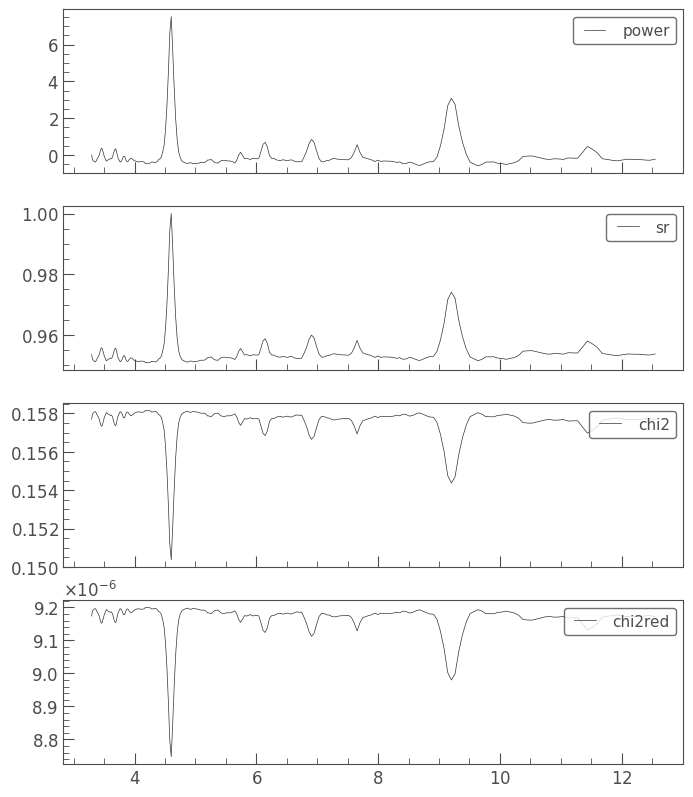

In [348]:
with plt.style.context(lk.MPLSTYLE):
    spectra = ['power', 'sr', 'chi2', 'chi2red']
    fig, axs = plt.subplots(len(spectra), 1, sharex=True, figsize=(8, len(spectra) * 2.5))
    for ax, spectrum in zip(axs, spectra):
        ax.plot(pg.period.value, getattr(pg, spectrum), label=spectrum)
        ax.legend(loc="upper right");

# Validate the statistics generated
- TODO: using K2-110 b (EPIC 212521166) , it is discussed in the section 3.2 of the [TLS paper](https://arxiv.org/pdf/1901.02015.pdf)


# OPEN: 

## run TLS in BLS model, and compare it against BLS

## Use TLS duration / period grid in BLS
- https://github.com/hippke/tls/blob/master/tutorials/09%20Optimal%20period%20grid%20and%20optimal%20duration%20grid.ipynb
